### Deep Learning
#### Compute the solution to the model when you use a neural network with three layers and 25 nodes per layer on capital and a three-point finite approximation to $z_t$ using Tauchen’s method. 

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import norm
import matplotlib.pyplot as plt


In [3]:
class Params:
    def __init__(self):
        # Technology parameters
        self.alpha = 0.33  # Capital share
        self.beta = 0.97   # Time discount factor
        self.delta = 0.1   # Depreciation rate
        self.rho = 1 / self.beta - 1  # Time discount rate

        # Productivity shock parameters
        self.rho_z = 0.95  # Persistence of productivity shocks
        self.sigma_e = 0.007  # Standard deviation of productivity shocks

        # Utility parameters
        self.psi = 1.0  # Inverse Frisch elasticity
        self.sigma = 1.0  # CRRA parameter

        # Parameters for Tauchen's      
        self.num_z = 5       # Number of grid points for z
        self.grid_std = 3    # Number of standard deviations to cover

        self.num_k = 25
        


In [4]:
# Production function with productivity shock
def prod_fn(k, l, z, params):
    return np.exp(z) * (k ** params.alpha) * (l ** (1 - params.alpha))

# Marginal product of capital
def rtn_to_capital(k, l, z, params):
    return np.exp(z) * params.alpha * (k ** (params.alpha - 1)) * (l ** (1 - params.alpha))

# Marginal utility of consumption
def u_prime(c, params):
    return c ** (-params.sigma)


In [5]:
class SteadyState:
    def __init__(self, params):
        self.params = params
        self.z_ss = 0 
        self.solve_steady_state()

    def solve_steady_state(self):
        """
        Compute the steady-state values for capital, labor, consumption, and output.
        """
        p = self.params
        z = self.z_ss

        y_to_k = (p.delta + p.rho) / p.alpha
        k_to_l = y_to_k ** (1 / (p.alpha - 1))
        css = (k_to_l ** p.alpha - p.delta * k_to_l) * ((1 - p.alpha) * (k_to_l ** p.alpha)) ** (1 / p.psi)
        css = css ** (1 / (1 + p.sigma / p.psi))
        lss = ((1 - p.alpha) * (k_to_l ** p.alpha) * css ** (-p.sigma)) ** (1 / p.psi)
        kss = k_to_l * lss
        yss = y_to_k * kss

        self.k_ss = kss
        self.l_ss = lss
        self.c_ss = css
        self.y_ss = yss

        
    def get_steady_state(self):
        """
        Return the steady-state values as a dictionary.
        """
        return {
            "k_ss": self.k_ss,
            "l_ss": self.l_ss,
            "c_ss": self.c_ss,
            "y_ss": self.y_ss,
        }

# Initialize parameters
params = Params()

# Solve for the steady state
steady_state = SteadyState(params)
ss_values = steady_state.get_steady_state()

# Print steady-state results
print("\nSteady State variables: \n")
for key, value in ss_values.items():
    print(f"{key}: {value:.4f}")



Steady State variables: 

k_ss: 3.7612
l_ss: 0.9465
c_ss: 1.1161
y_ss: 1.4923


In [6]:
# Tauchen's Method for Discretizing Productivity Shocks
def tauchen(rho, sigma, m=3, n=7):
    """
    Tauchen's method to discretize the AR(1) process:
        z_t = rho * z_{t-1} + sigma * epsilon_t
    where epsilon_t ~ N(0, 1).

    Parameters:
    - rho: AR(1) persistence parameter
    - sigma: Standard deviation of the shocks
    - m: Number of standard deviations to cover in the grid
    - n: Number of grid points

    Returns:
    - z: Grid for the state variable
    - pi: Transition probability matrix
    """
    # Standard deviation of the stationary distribution
    std_z = sigma / np.sqrt(1 - rho**2)

    # Create evenly spaced grid for z
    z_max = m * std_z
    z_min = -z_max
    z = np.linspace(z_min, z_max, n)
    step = (z_max - z_min) / (n - 1)

    # Transition probability matrix
    pi = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if j == 0:
                pi[i, j] = norm.cdf((z[0] - rho * z[i] + step / 2) / sigma)
            elif j == n - 1:
                pi[i, j] = 1 - norm.cdf((z[j] - rho * z[i] - step / 2) / sigma)
            else:
                pi[i, j] = (
                    norm.cdf((z[j] - rho * z[i] + step / 2) / sigma)
                    - norm.cdf((z[j] - rho * z[i] - step / 2) / sigma)
                )
    return z, pi

# Discretize productivity shocks
z_grid, z_prob = tauchen(params.rho_z, params.sigma_e, m=params.grid_std, n=params.num_z)

In [7]:
# Capital grid
cover_grid = 0.25        # Fractional coverage around the steady-state
k_min = steady_state.k_ss * (1 - cover_grid)
k_max = steady_state.k_ss * (1 + cover_grid)
num_k = 1001             # Number of grid points for k
k_grid = np.linspace(k_min, k_max, num_k)


In [8]:
# Define the state grid for k and z

class Grid_data:
    def __init__(self, k_min, k_max, num_k, z_grid, z_prob):
        self.k_grid = np.linspace(k_min, k_max, num_k)
        self.z_grid = z_grid
        self.z_prob = z_prob
        self.num_k = num_k
        self.num_z = len(z_grid)

    def sample(self, num_samples):
        k_samples = np.random.choice(self.k_grid, size=num_samples)
        z_samples = np.random.choice(self.z_grid, size=num_samples, p=self.z_prob.mean(axis=0))
        return torch.tensor(np.column_stack((k_samples, z_samples)), dtype=torch.float32)

data = Grid_data(k_min, k_max, params.num_k, z_grid, z_prob)



In [105]:
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_size = 2
hidden_size = params.num_k
output_size = 1
model = NeuralNetwork(input_size, hidden_size, output_size)

# Marginal utility
def marginal_utility(c, sigma):
    return c ** -sigma

# Training loop
optimizer = optim.Adam(model.parameters(), lr=0.0005)
# optimizer = optim.SGD(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()

num_epochs = 3000+1
batch_size = 64

for epoch in range(num_epochs):
    # Sample training data
    samples = data.sample(batch_size)
    k = samples[:, 0].unsqueeze(1)
    z = samples[:, 1].unsqueeze(1)

    # Predict next-period capital k_{t+1}
    k_next = model(samples)

    # Clamp k_next to ensure it's within reasonable bounds
    k_next = torch.clamp(k_next, min=k_min, max=k_max)

    # Compute labor using the intratemporal condition
    c_temp = k ** params.alpha * torch.exp(z) - k_next + (1 - params.delta) * k
    c_temp = torch.clamp(c_temp, min=1e-6)  # Ensure positive consumption
    l = (((1 - params.alpha) * k ** params.alpha * torch.exp(z)) / c_temp) ** (1 / (1 + params.alpha))

    # Compute consumption
    c = k ** params.alpha * l ** (1 - params.alpha) * torch.exp(z) - k_next + (1 - params.delta) * k
    c = torch.clamp(c, min=1e-6)  # Ensure positive consumption

    # Compute Euler equation error
    next_samples = data.sample(batch_size)
    k_next_next = model(next_samples)
    k_next_next = torch.clamp(k_next_next, min=k_min, max=k_max)
    z_next = next_samples[:, 1].unsqueeze(1)
    l_next = (((1 - params.alpha) * k_next ** params.alpha * torch.exp(z_next)) / c) ** (1 / (1 + params.alpha))
    c_next = k_next ** params.alpha * l_next ** (1 - params.alpha) * torch.exp(z_next) - k_next_next + (1 - params.delta) * k_next
    c_next = torch.clamp(c_next, min=1e-6)  # Ensure positive consumption

    mrs = marginal_utility(c_next, params.sigma) * (params.alpha * k_next ** (params.alpha - 1) * l_next ** (1 - params.alpha) * torch.exp(z_next) + 1 - params.delta)
    euler_error = marginal_utility(c, params.sigma) - params.beta * mrs.mean()

    # Loss is the Euler equation error
    loss = torch.mean(euler_error ** 2)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.6f}")

Epoch [0/3001], Loss: 0.410589
Epoch [100/3001], Loss: 0.522164
Epoch [200/3001], Loss: 0.448934
Epoch [300/3001], Loss: 0.422866
Epoch [400/3001], Loss: 0.451723
Epoch [500/3001], Loss: 0.455512
Epoch [600/3001], Loss: 0.428702
Epoch [700/3001], Loss: 0.469660
Epoch [800/3001], Loss: 0.598500
Epoch [900/3001], Loss: 0.424493
Epoch [1000/3001], Loss: 0.377241
Epoch [1100/3001], Loss: 0.411578
Epoch [1200/3001], Loss: 0.444541
Epoch [1300/3001], Loss: 0.444633
Epoch [1400/3001], Loss: 0.330161
Epoch [1500/3001], Loss: 0.403710
Epoch [1600/3001], Loss: 0.556187
Epoch [1700/3001], Loss: 0.470960
Epoch [1800/3001], Loss: 0.327414
Epoch [1900/3001], Loss: 0.472259
Epoch [2000/3001], Loss: 0.420454
Epoch [2100/3001], Loss: 0.445309
Epoch [2200/3001], Loss: 0.488796
Epoch [2300/3001], Loss: 0.467641
Epoch [2400/3001], Loss: 0.357878
Epoch [2500/3001], Loss: 0.450041
Epoch [2600/3001], Loss: 0.459641
Epoch [2700/3001], Loss: 0.344653
Epoch [2800/3001], Loss: 0.450768
Epoch [2900/3001], Loss: 0

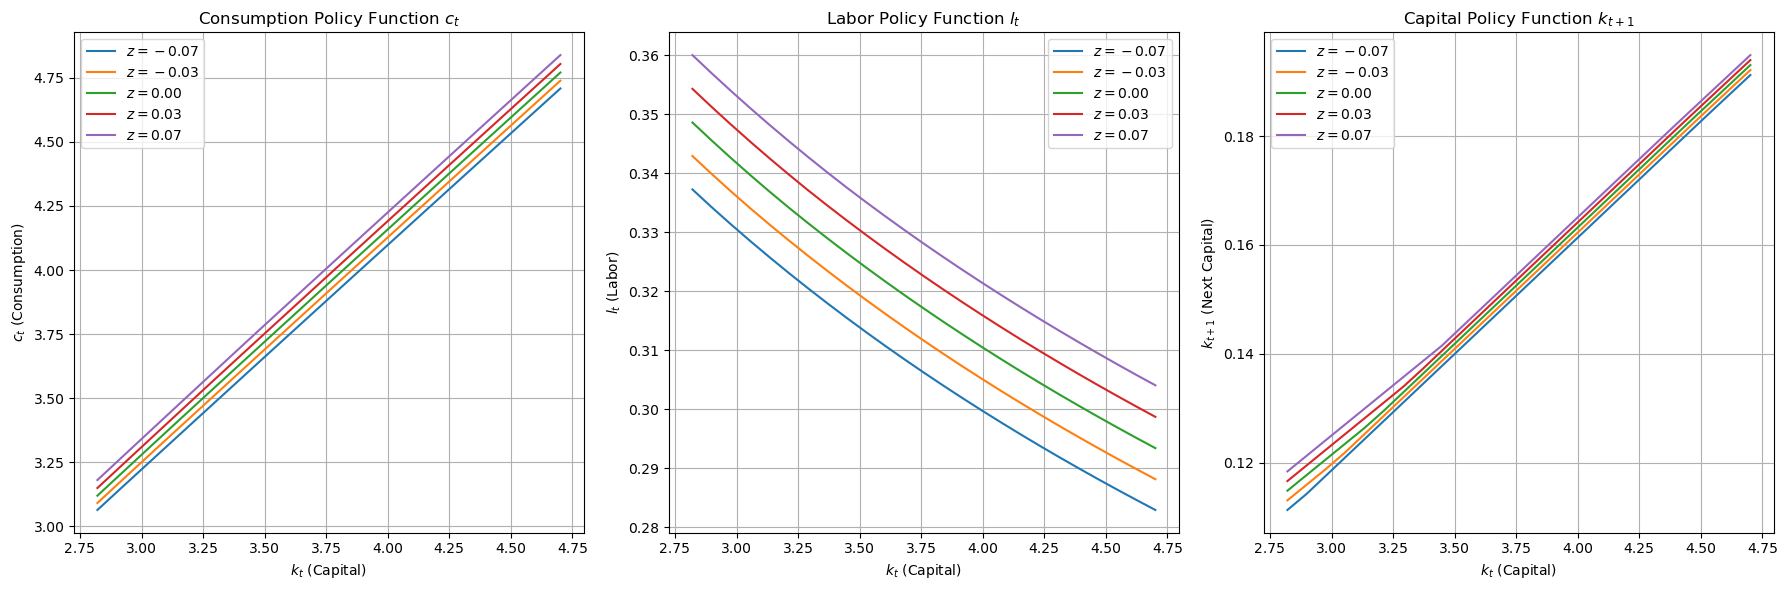

In [106]:
k_values = data.k_grid
z_values = data.z_grid

# Initialize plots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Labels and titles
titles = ["Consumption Policy Function $c_t$", "Labor Policy Function $l_t$", "Capital Policy Function $k_{t+1}$"]
ylabels = ["$c_t$ (Consumption)", "$l_t$ (Labor)", "$k_{t+1}$ (Next Capital)"]

for idx, z in enumerate(z_values):
    inputs = np.column_stack((k_values, np.full_like(k_values, z)))
    inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
    predictions = model(inputs_tensor).detach().numpy()

    # Compute decision rules
    k_next_policy = predictions.flatten()
    l_policy = (((1 - params.alpha) * k_values ** params.alpha * np.exp(z)) / (k_values ** params.alpha * np.exp(z) - k_next_policy + (1 - params.delta) * k_values)) ** (1 / (1 + params.alpha))
    c_policy = k_values ** params.alpha * l_policy ** (1 - params.alpha) * np.exp(z) - k_next_policy + (1 - params.delta) * k_values

    # Plot each policy function
    axs[0].plot(k_values, c_policy, label=f"$z = {z:.2f}$")
    axs[1].plot(k_values, l_policy, label=f"$z = {z:.2f}$")
    axs[2].plot(k_values, k_next_policy, label=f"$z = {z:.2f}$")

# Finalize each subplot
for i in range(3):
    axs[i].set_title(titles[i])
    axs[i].set_xlabel("$k_t$ (Capital)")
    axs[i].set_ylabel(ylabels[i])
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()